In [1]:
%load_ext autoreload
%autoreload 2    

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.tree import *
from spatial_scene_grammars.sampling import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

Unconditional grammar outputs look like this:

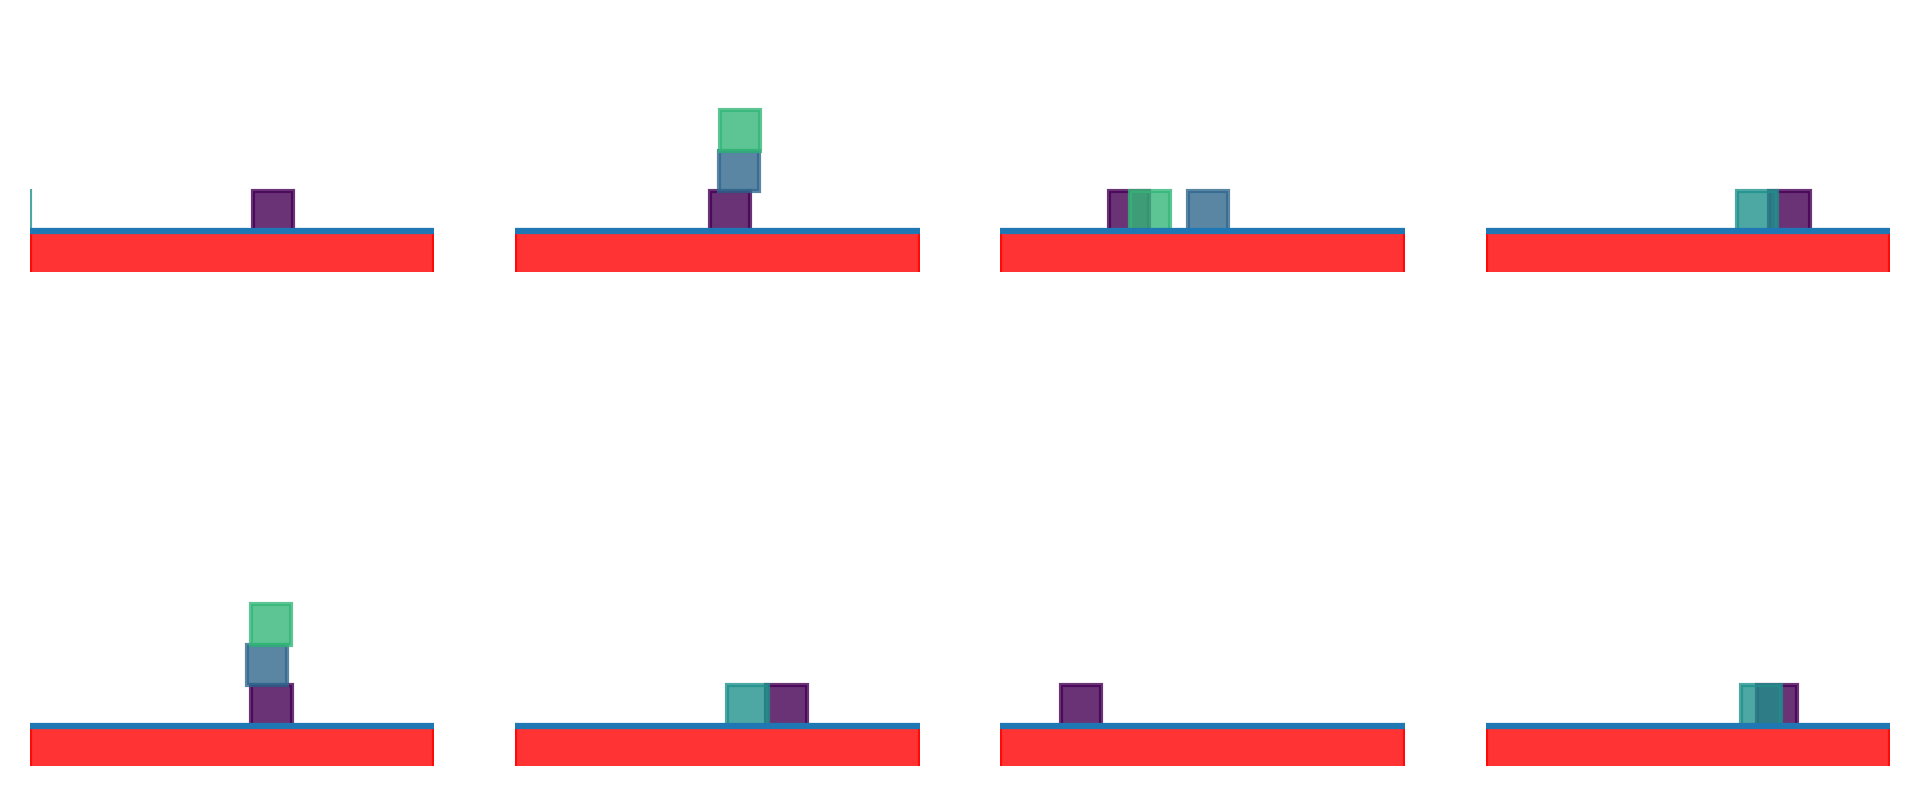

In [5]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(43)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = SceneTree.forward_sample_from_root_type(
                Ground, {"xy": torch.tensor([0., 0.])})
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

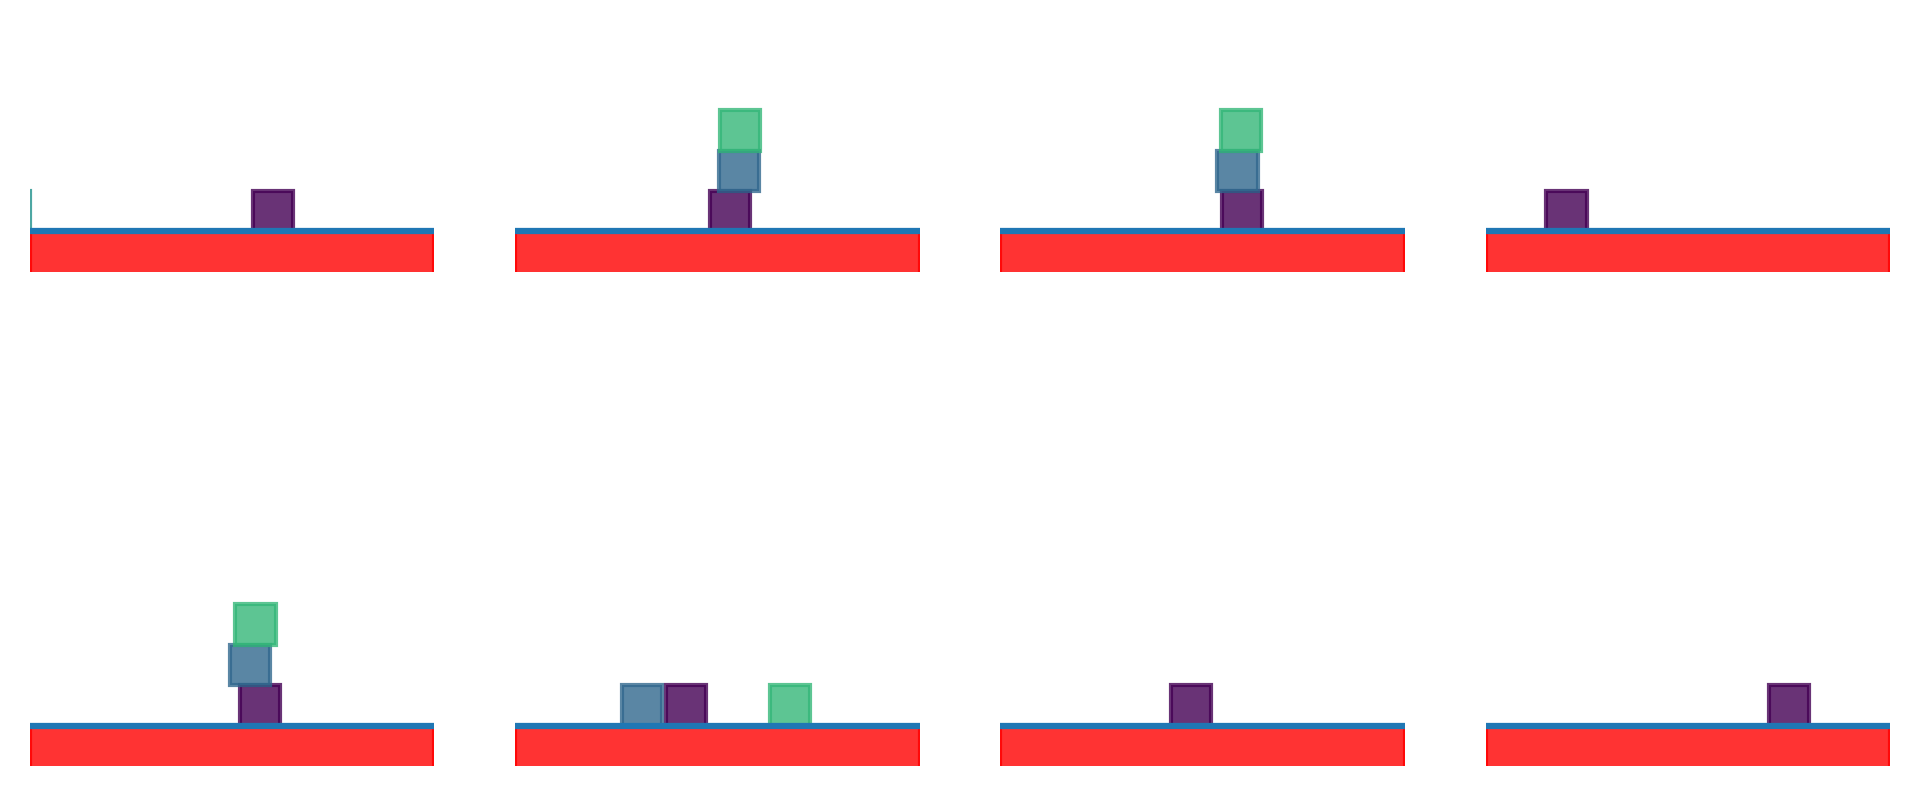

In [7]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(43)
observed_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict={
                "xy": torch.tensor([0., 0.])
            },
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_trees.append(scene_trees[0])
plt.show()

The "meta" ("hyper"? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(324.68379999999996, 709.9961999999999, -16.899900000000002, 385.2799)

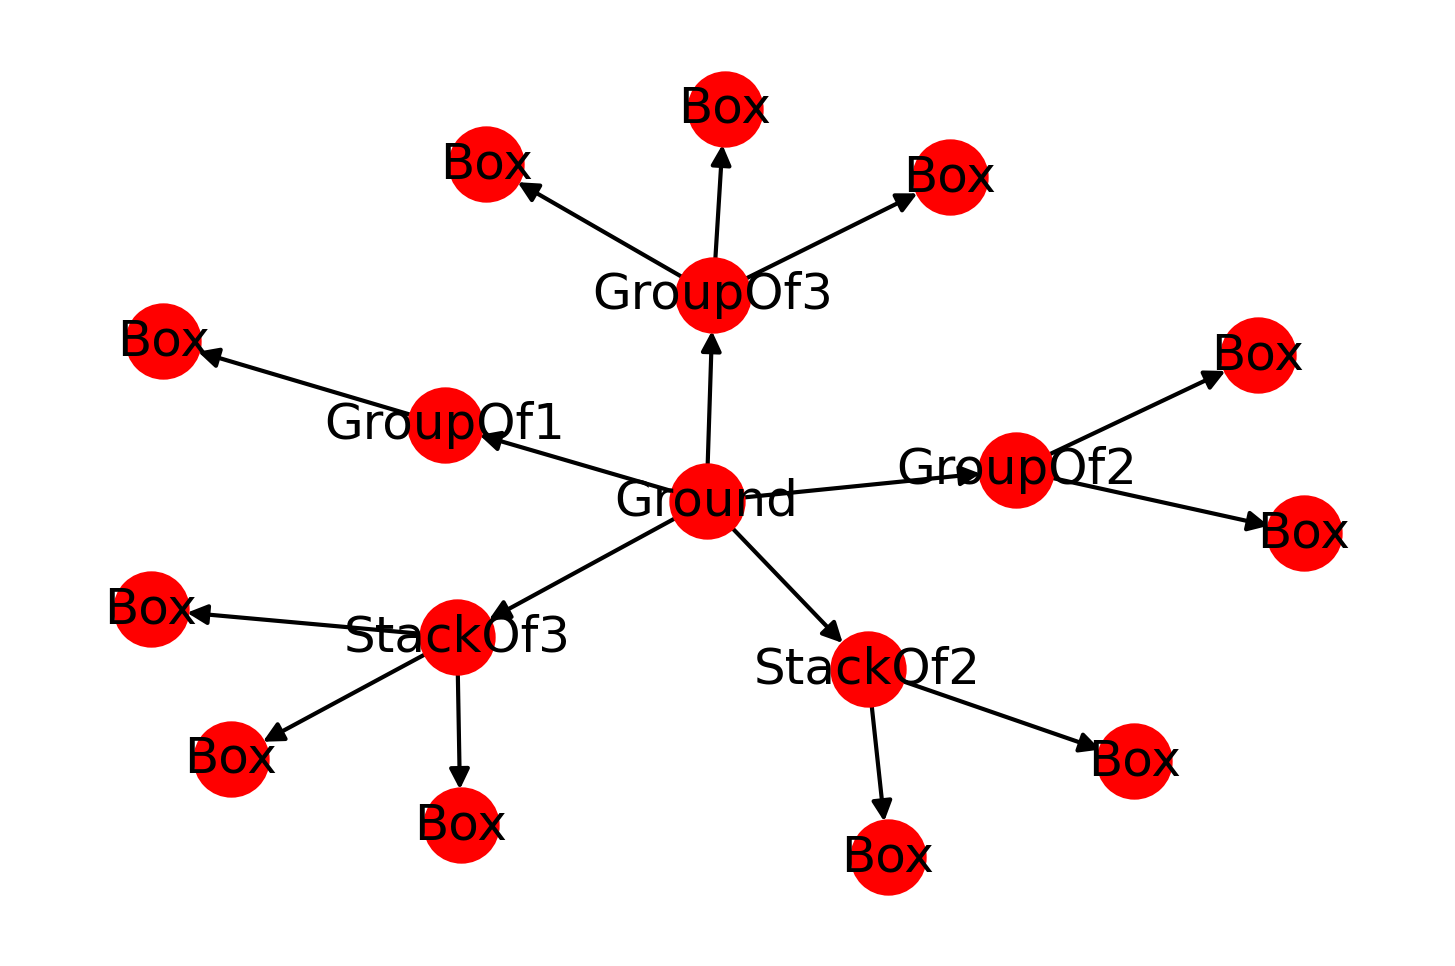

In [8]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneTree.make_meta_scene_tree(Ground())
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.